In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft 
from scipy import linalg as la
from scipy import signal
from scipy import optimize
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
#from scipy.signal import find_peaks


In [2]:
# what are we doing? we are trying to get the heart rate (HR) and resipiratory rate (RR)
# how are we going to do this?
# using two techniques, SCG and BCG, that need
# info about the mechanical properties of the human body such as acceleration, angular velocity

# first things first, we load the center_sternum dataset and add a time column as index

df=pd.read_csv("center_sternum.txt",sep=None,engine='python')
df['time_s'] = np.arange(0,df.shape[0])/200 # let's construct the time axis, with each sampling separated by a 200th of a second (because sampling rate is 200 Hz)
df=df.set_index('time_s')
df

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
time_s,,,,,,,,,,,,,,,,
0.000,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
0.005,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
0.010,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
0.015,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
0.020,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82.505,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
82.510,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
82.515,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502


In [3]:
#drop some columns 

new_df=df.drop(columns=['Log Mode','Log Freq','Timestamp','MagnX','MagnY','MagnZ','qw','qi','qj','qk'])
new_df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
time_s,,,,,,
0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580
0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466
0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382
0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733
0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267
...,...,...,...,...,...,...
82.505,958.493,291.092,-54.290,1.664122,2.305344,-0.671756
82.510,954.650,288.042,-49.654,1.480916,2.488550,-0.702290
82.515,967.338,290.482,-63.867,1.114504,3.374046,-0.900763


<AxesSubplot:title={'center':'Second Time Window'}, xlabel='time_s'>

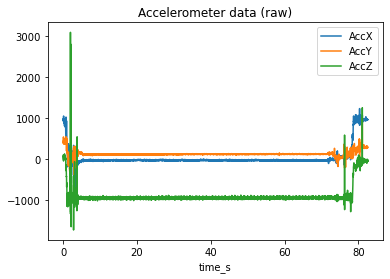

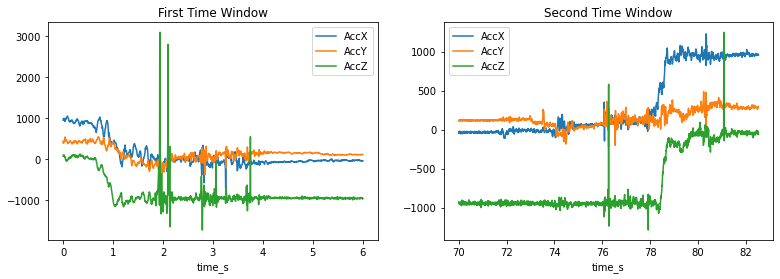

In [4]:
# now let's look at the acceleration vector by plotting its three components

new_df.plot(y=['AccX','AccY','AccZ'], title= 'Accelerometer data (raw)')

figure, axes = plt.subplots(1, 2, figsize=(13,4))
new_df.loc[0:6].plot(ax=axes[0],y=['AccX','AccY','AccZ'],title='First Time Window')
new_df.loc[70:].plot(ax=axes[1],y=['AccX','AccY','AccZ'],title='Second Time Window')

In [5]:
#clean up the data (we select a time intervall from 9s to 71s)

data=new_df.loc[9:71].copy()

data

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
time_s,,,,,,
9.000,-25.071,114.314,-970.083,-2.732824,2.900763,-0.473282
9.005,-32.635,106.811,-953.125,-2.839695,3.160305,-0.946565
9.010,-28.487,110.959,-966.606,-3.267176,2.839695,-0.625954
9.015,-38.918,104.005,-960.994,-2.977099,2.793893,-0.961832
9.020,-29.036,105.286,-980.026,-3.282443,3.083970,-0.824427
...,...,...,...,...,...,...
70.980,-33.794,123.769,-939.522,0.717557,5.847328,-0.137405
70.985,-32.269,125.538,-953.003,0.488550,4.748092,-0.320611
70.990,-38.369,121.146,-956.297,-0.488550,4.885496,-0.824427


<AxesSubplot:title={'center':'Gyroscope data'}, xlabel='time_s'>

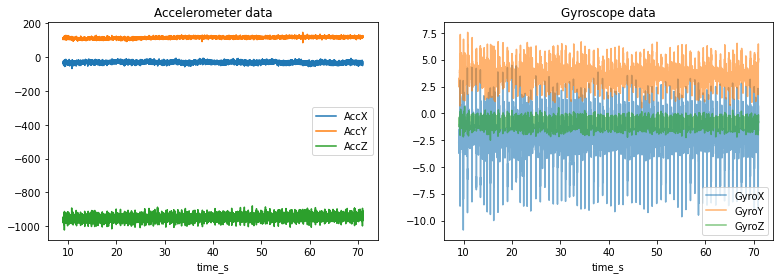

In [6]:
figure, axes = plt.subplots(1, 2, figsize=(13,4))
data.plot(ax=axes[0],y=['AccX','AccY','AccZ'],title= 'Accelerometer data')
data.plot(ax=axes[1],y=['GyroX','GyroY','GyroZ'],title= 'Gyroscope data',alpha=0.6)

In [7]:
#normalize dataset

data=(data-data.mean())/data.std()
data

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
time_s,,,,,,
9.000,0.813353,-0.243179,-1.448413,-0.451122,-1.081837,1.079334
9.005,-0.263693,-1.648478,-0.278397,-0.525964,-0.722329,-0.216252
9.010,0.326945,-0.871565,-1.208518,-0.825332,-1.166426,0.661403
9.015,-1.158337,-2.174037,-0.821318,-0.622189,-1.229869,-0.258045
9.020,0.248772,-1.934108,-2.134430,-0.836023,-0.828066,0.118093
...,...,...,...,...,...,...
70.980,-0.428725,1.527725,0.660141,1.965201,2.999633,1.998782
70.985,-0.211578,1.859056,-0.269980,1.804825,1.477013,1.497265
70.990,-1.080164,1.036442,-0.497249,1.120557,1.667340,0.118093


In [8]:
data.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
count,1.240100e+04,1.240100e+04,1.240100e+04,1.240100e+04,1.240100e+04,1.240100e+04
mean,-2.649540e-15,-1.888348e-14,-2.648259e-13,3.637567e-16,-6.290321e-15,-1.401338e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.145146e+00,-5.578744e+00,-5.055261e+00,-6.160490e+00,-4.401996e+00,-4.479147e+00
25%,-6.545570e-01,-6.544863e-01,-5.940489e-01,-4.190471e-01,-5.742957e-01,-6.341835e-01
50%,5.568307e-03,3.102519e-02,-3.008428e-02,-4.483786e-02,-6.675570e-02,3.450697e-02
75%,6.656936e-01,6.708359e-01,5.422977e-01,4.255969e-01,4.407843e-01,6.614032e-01
max,3.610200e+00,5.949275e+00,4.784658e+00,4.595357e+00,5.368155e+00,4.130229e+00


<AxesSubplot:xlabel='time [s]', ylabel='[A.U.]'>

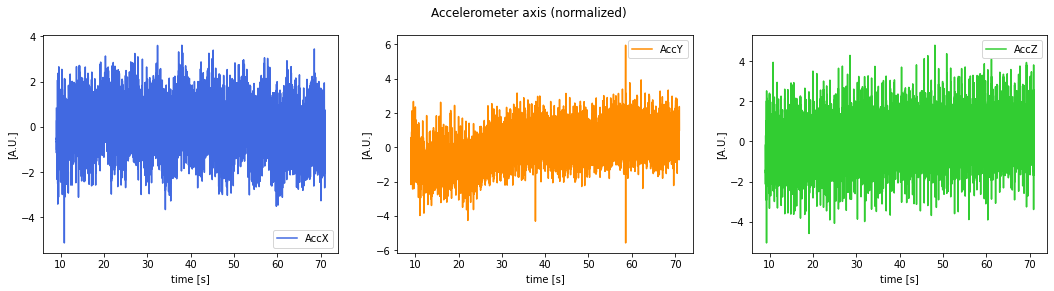

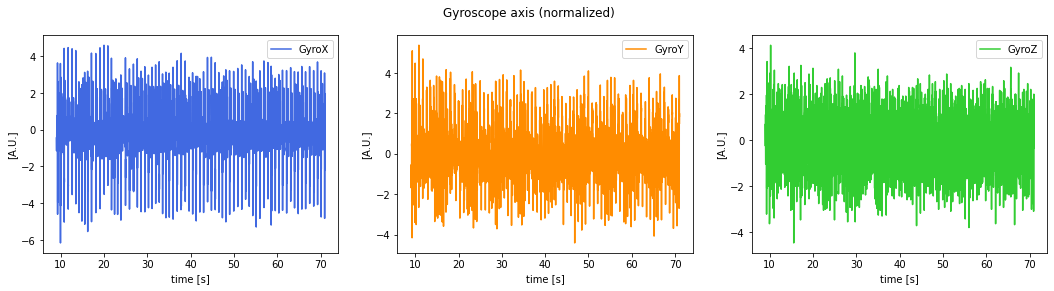

In [9]:
#accelerometer plots

figure, axes = plt.subplots(1, 3, figsize=(18,4))
figure.suptitle('Accelerometer axis (normalized)')
data.plot(ax=axes[0],y=['AccX'],color='royalblue', ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[1],y=['AccY'],color='darkorange',ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[2],y=['AccZ'],color='limegreen', ylabel='[A.U.]', xlabel='time [s]')

#gyroscope plots

figure, axes = plt.subplots(1, 3, figsize=(18,4))
figure.suptitle('Gyroscope axis (normalized)')
data.plot(ax=axes[0],y=['GyroX'],color='royalblue', ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[1],y=['GyroY'],color='darkorange',ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[2],y=['GyroZ'],color='limegreen', ylabel='[A.U.]', xlabel='time [s]')

          AccX      AccY      AccZ
AccX  1.000000 -0.181833 -0.407972
AccY -0.181833  1.000000  0.174179
AccZ -0.407972  0.174179  1.000000 

Contributions to variance along the three eigenvectors' direction:
[0.197 0.293 0.509]


array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>]], dtype=object)

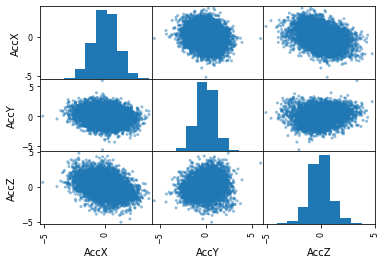

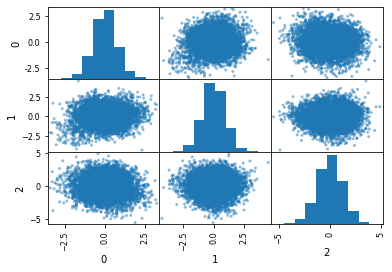

In [10]:
#PCA acc

c_acc=data[['AccX','AccY','AccZ']].cov()
print(c_acc,'\n')
l_acc,V_acc=la.eigh(c_acc) #V[:,i] is the normalized eigenvector corresponding to the l[i] eigenvalue 

print("Contributions to variance along the three eigenvectors' direction:")
with np.printoptions(precision=3, suppress=True):
    print(l_acc/c_acc.values.trace()) 
data_acc_transf = (V_acc.T @ data[['AccX','AccY','AccZ']].T).T

pd.plotting.scatter_matrix(data[['AccX','AccY','AccZ']])
pd.plotting.scatter_matrix(data_acc_transf)

          GyroX     GyroY     GyroZ
GyroX  1.000000  0.402625  0.390450
GyroY  0.402625  1.000000  0.436916
GyroZ  0.390450  0.436916  1.000000 

Contributions to variance along the three eigenvectors' direction:
[0.187 0.206 0.607]


array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>]], dtype=object)

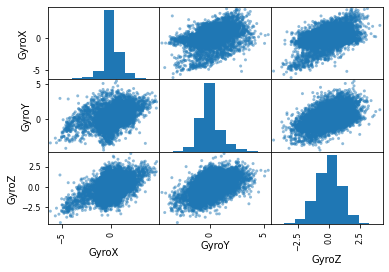

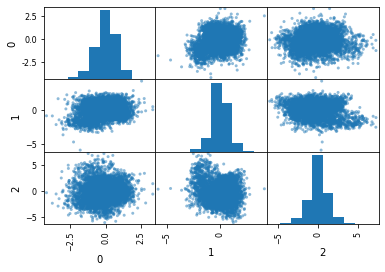

In [11]:
#PCA gyro

c_gyro=data[['GyroX','GyroY','GyroZ']].cov()
print(c_gyro,'\n')
l_gyro,V_gyro=la.eigh(c_gyro) #V[:,i] is the normalized eigenvector corresponding to the l[i] eigenvalue 

print("Contributions to variance along the three eigenvectors' direction:")
with np.printoptions(precision=3, suppress=True):
    print(l_gyro/c_gyro.values.trace()) 
data_gyro_transf = (V_gyro.T @ data[['GyroX','GyroY','GyroZ']].T).T

pd.plotting.scatter_matrix(data[['GyroX','GyroY','GyroZ']])
pd.plotting.scatter_matrix(data_gyro_transf)

Text(0, 0.5, 'Power')

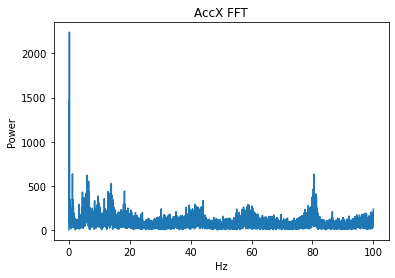

In [12]:
#fft on acc

time_step=0.005

accX=data['AccX'].values
accY=data['AccY'].values
accZ=data['AccZ'].values

fft_accX=fft.fft(accX)
accX_freq = fft.fftfreq(accX.size, d=time_step)
power_accX = np.abs(fft_accX)

mask=np.where(accX_freq>=0)

accX_freq1=accX_freq[mask]
power_accX1=power_accX[mask]

fig, ax = plt.subplots()
ax.plot(accX_freq1,power_accX1)
ax.set_title('AccX FFT')
ax.set_xlabel('Hz')
ax.set_ylabel('Power')


Text(0, 0.5, '[A.U.]')

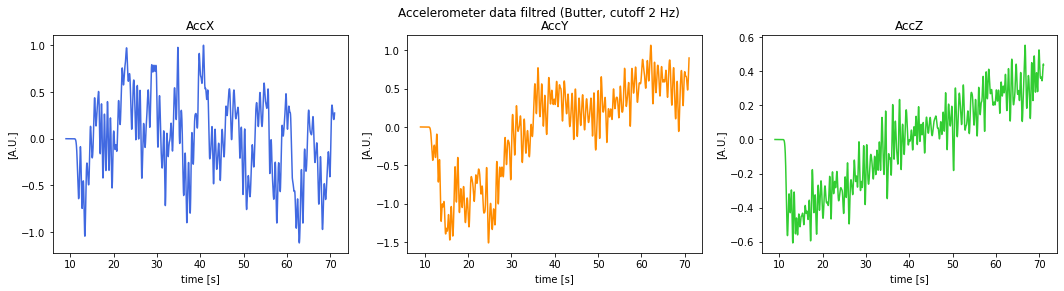

In [13]:
#butter filter on acc, cutoff 2Hz

t=np.linspace(9, 71, len(accX))
N=50
sos = signal.butter(N, 2, 'lp', fs=200, output='sos')

filtered_accX = signal.sosfilt(sos, accX)
filtered_accY = signal.sosfilt(sos, accY)
filtered_accZ = signal.sosfilt(sos, accZ)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
fig.suptitle('Accelerometer data filtred (Butter, cutoff 2 Hz)')
ax[0].plot(t,filtered_accX,color='royalblue')
ax[0].set_title('AccX')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('[A.U.]')

ax[1].plot(t,filtered_accY,color='darkorange')
ax[1].set_title('AccY')
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('[A.U.]')

ax[2].plot(t,filtered_accZ,color='limegreen')
ax[2].set_title('AccZ')
ax[2].set_xlabel('time [s]')
ax[2].set_ylabel('[A.U.]')





Text(0, 0.5, 'Power')

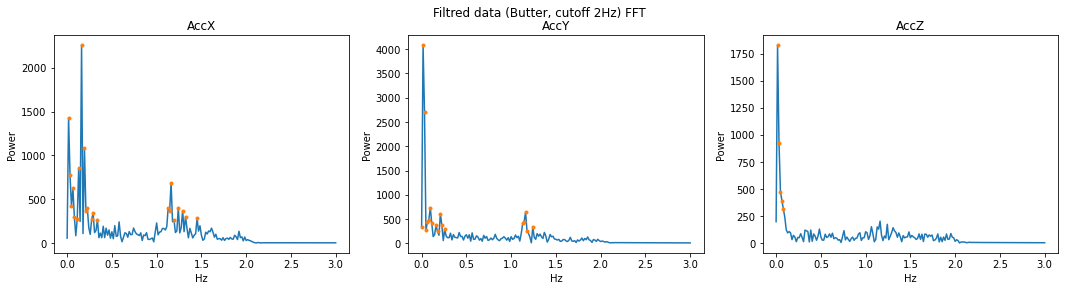

In [21]:
#fft filtred acc  data (butter)

h_p=250   #trashold peaks

#-----------------------------------------------
fft_accX_fil=fft.fft(filtered_accX)
accX_freq_fil = fft.fftfreq(filtered_accX.size, d=time_step)
power_accX_fil = np.abs(fft_accX_fil)

mask_fil=np.where(accX_freq_fil>=0)

accX_freq_fil1=accX_freq_fil[mask_fil]
power_accX_fil1=power_accX_fil[mask_fil]

mask_fil1=np.where(accX_freq_fil1<=3)

peaks_accX= accX_freq_fil1[np.where(power_accX_fil1>h_p)]
#-----------------------------------------------
fft_accY_fil=fft.fft(filtered_accY)
accY_freq_fil = fft.fftfreq(filtered_accY.size, d=time_step)
power_accY_fil = np.abs(fft_accY_fil)

mask_fil=np.where(accY_freq_fil>=0)

accY_freq_fil1=accY_freq_fil[mask_fil]
power_accY_fil1=power_accY_fil[mask_fil]

mask_fil1=np.where(accY_freq_fil1<=3)

peaks_accY= accY_freq_fil1[np.where(power_accY_fil1>h_p)]
#-----------------------------------------------
fft_accZ_fil=fft.fft(filtered_accZ)
accZ_freq_fil = fft.fftfreq(filtered_accZ.size, d=time_step)
power_accZ_fil = np.abs(fft_accZ_fil)

mask_fil=np.where(accZ_freq_fil>=0)

accZ_freq_fil1=accZ_freq_fil[mask_fil]
power_accZ_fil1=power_accZ_fil[mask_fil]

mask_fil1=np.where(accZ_freq_fil1<=3)

peaks_accZ= accZ_freq_fil1[np.where(power_accZ_fil1>h_p)]
#-----------------------------------------------

#plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
fig.suptitle('Filtred data (Butter, cutoff 2Hz) FFT')

ax[0].plot(accX_freq_fil1[mask_fil1],power_accX_fil1[mask_fil1])
ax[0].plot(peaks_accX,power_accX_fil1[np.where(power_accX_fil1>h_p)], '.')
ax[0].set_title('AccX')
ax[0].set_xlabel('Hz')
ax[0].set_ylabel('Power')

ax[1].plot(accY_freq_fil1[mask_fil1],power_accY_fil1[mask_fil1])
ax[1].plot(peaks_accY,power_accY_fil1[np.where(power_accY_fil1>h_p)], '.')
ax[1].set_title('AccY')
ax[1].set_xlabel('Hz')
ax[1].set_ylabel('Power')

ax[2].plot(accZ_freq_fil1[mask_fil1],power_accZ_fil1[mask_fil1])
ax[2].plot(peaks_accZ,power_accZ_fil1[np.where(power_accZ_fil1>h_p)], '.')
ax[2].set_title('AccZ')
ax[2].set_xlabel('Hz')
ax[2].set_ylabel('Power')


Text(0, 0.5, 'Power')

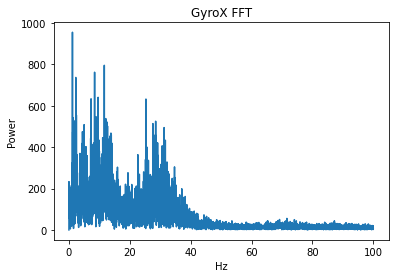

In [22]:
#gyroscope

gyrX=data['GyroX'].values
gyrY=data['GyroY'].values
gyrZ=data['GyroZ'].values

fft_gyrX=fft.fft(gyrX)
gyrX_freq = fft.fftfreq(gyrX.size, d=time_step)
power_gyrX = np.abs(fft_gyrX)

mask=np.where(gyrX_freq>=0)

gyrX_freq1=gyrX_freq[mask]
power_gyrX1=power_gyrX[mask]

fig, ax = plt.subplots()
ax.plot(gyrX_freq1,power_gyrX1)
ax.set_title('GyroX FFT')
ax.set_xlabel('Hz')
ax.set_ylabel('Power')

Text(0, 0.5, '[A.U.]')

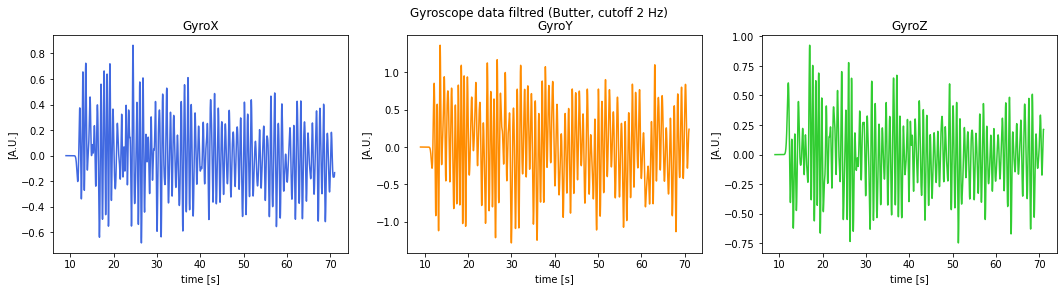

In [23]:
#butter filter on gyroX, cutoff 2Hz


filtered_gyrX = signal.sosfilt(sos, gyrX)
filtered_gyrY = signal.sosfilt(sos, gyrY)
filtered_gyrZ = signal.sosfilt(sos, gyrZ)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
fig.suptitle('Gyroscope data filtred (Butter, cutoff 2 Hz)')

ax[0].plot(t,filtered_gyrX,color='royalblue')
ax[0].set_title('GyroX')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('[A.U.]')

ax[1].plot(t,filtered_gyrY,color='darkorange')
ax[1].set_title('GyroY')
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('[A.U.]')

ax[2].plot(t,filtered_gyrZ,color='limegreen')
ax[2].set_title('GyroZ')
ax[2].set_xlabel('time [s]')
ax[2].set_ylabel('[A.U.]')



Text(0, 0.5, 'Power')

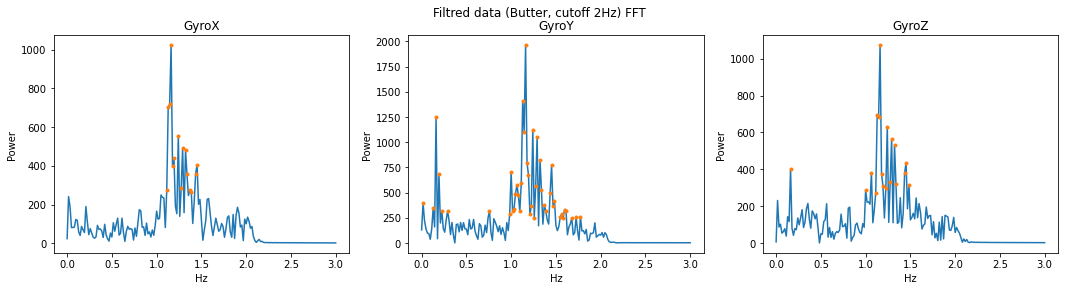

In [24]:
#-----------------------------------------------
fft_gyrX_fil=fft.fft(filtered_gyrX)
gyrX_freq_fil = fft.fftfreq(filtered_gyrX.size, d=time_step)
power_gyrX_fil = np.abs(fft_gyrX_fil)

mask_fil=np.where(gyrX_freq_fil>=0)

gyrX_freq_fil1=gyrX_freq_fil[mask_fil]
power_gyrX_fil1=power_gyrX_fil[mask_fil]

mask_fil1=np.where(gyrX_freq_fil1<=3)
peaks_gyrX= gyrX_freq_fil1[np.where(power_gyrX_fil1>h_p)]
#-----------------------------------------------
fft_gyrY_fil=fft.fft(filtered_gyrY)
gyrY_freq_fil = fft.fftfreq(filtered_gyrY.size, d=time_step)
power_gyrY_fil = np.abs(fft_gyrY_fil)

mask_fil=np.where(gyrY_freq_fil>=0)

gyrY_freq_fil1=gyrY_freq_fil[mask_fil]
power_gyrY_fil1=power_gyrY_fil[mask_fil]

mask_fil1=np.where(gyrY_freq_fil1<=3)
peaks_gyrY= gyrY_freq_fil1[np.where(power_gyrY_fil1>h_p)]
#-----------------------------------------------
fft_gyrZ_fil=fft.fft(filtered_gyrZ)
gyrZ_freq_fil = fft.fftfreq(filtered_gyrZ.size, d=time_step)
power_gyrZ_fil = np.abs(fft_gyrZ_fil)

mask_fil=np.where(gyrZ_freq_fil>=0)

gyrZ_freq_fil1=gyrZ_freq_fil[mask_fil]
power_gyrZ_fil1=power_gyrZ_fil[mask_fil]

mask_fil1=np.where(gyrZ_freq_fil1<=3)
peaks_gyrZ= gyrZ_freq_fil1[np.where(power_gyrZ_fil1>h_p)]
#-----------------------------------------------


#plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
fig.suptitle('Filtred data (Butter, cutoff 2Hz) FFT')

ax[0].plot(gyrX_freq_fil1[mask_fil1],power_gyrX_fil1[mask_fil1])
ax[0].plot(peaks_gyrX,power_gyrX_fil1[np.where(power_gyrX_fil1>h_p)], '.')
ax[0].set_title('GyroX')
ax[0].set_xlabel('Hz')
ax[0].set_ylabel('Power')

ax[1].plot(gyrY_freq_fil1[mask_fil1],power_gyrY_fil1[mask_fil1])
ax[1].plot(peaks_gyrY,power_gyrY_fil1[np.where(power_gyrY_fil1>h_p)], '.')
ax[1].set_title('GyroY')
ax[1].set_xlabel('Hz')
ax[1].set_ylabel('Power')

ax[2].plot(gyrZ_freq_fil1[mask_fil1],power_gyrZ_fil1[mask_fil1])
ax[2].plot(peaks_gyrZ,power_gyrZ_fil1[np.where(power_gyrZ_fil1>h_p)], '.')
ax[2].set_title('GyroZ')
ax[2].set_xlabel('Hz')
ax[2].set_ylabel('Power')


Text(0, 0.5, 'Counts')

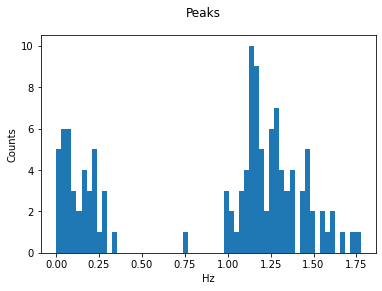

In [45]:
#let's try to obtain the cardiac freq

peaks=np.concatenate((peaks_accX,peaks_accY,peaks_accZ,peaks_gyrX,peaks_gyrY,peaks_gyrZ),axis=None)

n_bins=60

fig,ax = plt.subplots()
fig.suptitle('Peaks')
x,h,_= plt.hist(peaks,bins=n_bins)
ax.set_xlabel('Hz')
ax.set_ylabel('Counts')



Fit parametres:
 [ 3.82832556  1.14785541 -0.02349088  1.70080888] 

Heart Rate: 68.87132462572781 +/- 1.4094530690867015 ( 2.0465020481981284 %) bpm


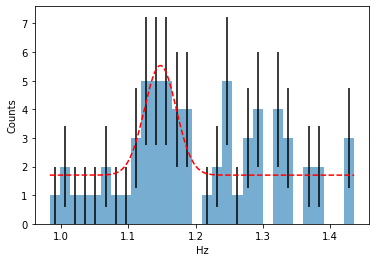

In [28]:
cardiac=np.where(abs(peaks-1.15152792)<1/np.sqrt(12))

def f(x,a,b,c,d):
    return a*np.exp(-pow(x-b,2)/(2*pow(c,2)))+d

x=peaks[cardiac]
n_bins=30

y,binEdges = np.histogram(x,bins=n_bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
yerr = np.sqrt(y)

popt, pcov = curve_fit(f, bincenters, y, maxfev=8000)
x_range=np.linspace(peaks[cardiac].min(),peaks[cardiac].max(),1000) 

fig,ax = plt.subplots()
ax.hist(peaks[cardiac],bins=n_bins, alpha=0.6)
ax.bar(bincenters, y, width=0, yerr=yerr)
ax.plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax.set_xlabel('Hz')
ax.set_ylabel('Counts')

perc=abs(popt[2]*100)/popt[1]
print('Fit parametres:\n', popt, '\n')
print('Heart Rate:',popt[1]*60, '+/-',abs(popt[2]*60),'(',perc,'%) bpm')